In [2]:
import torch 
import numpy as np
import time


def ui(x, y , model):
    return model(torch.cat((x.unsqueeze(-1), y.unsqueeze(-1)), dim=-1))

def f(x, y ,model):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,model)
    
   
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]

    
    
    return u_xx + u_yy 

def finite_difference_derivatives(x, y, model):
    dx = 2 / (len(x) - 1)
    du =2 / (len(y) - 1)
    u = ui(x, y ,model)
    # Calculate the derivative with respect to x
    dudx = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * dx)
    
    # Calculate the derivative with respect to y
    dudy = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / (2 * dy)

    dudyy = (np.roll(u, -1, axis=1) - 2 * u + np.roll(u, 1, axis=1)) / (dy ** 2)
    dudxx = (np.roll(u, -1, axis=0) - 2 * u + np.roll(u, 1, axis=0)) / (dx ** 2)
    
    
    return dudxx + dudyy

def f_fourier(x, y, model):
    # Compute Fourier coefficients of the solution
    u = ui(x, y, model)
    u_ft = torch.fft.fft2(u)
    
    # Get frequencies
    nx, ny = u.shape[-2], u.shape[-1]
    kx = torch.fft.fftfreq(nx, d=1/nx).to(u.device)
    ky = torch.fft.fftfreq(ny, d=1/ny).to(u.device)
    kx, ky = torch.meshgrid(kx, ky)
    
    # Compute derivatives in Fourier space
    u_xx_ft = -(kx**2) * u_ft
    u_yy_ft = -(ky**2) * u_ft
    
    # Transform back to physical space
    u_xx = torch.fft.ifft2(u_xx_ft).real
    u_yy = torch.fft.ifft2(u_yy_ft).real
    
    return u_xx + u_yy


def f2(x, y ,model):
    
    f_pred = f(x, y ,model)
    r = (f_pred - torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

 
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , model):
    u_pred = ui(x, -torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    
    

    return torch.mean((u_pred - u_boundary)**2)
def loss_boundary_2(x,model):

    
    
    u_pred = ui(x, torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_3(y,model):
    u_pred = ui(torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_4(y ,model):
    u_pred = ui(-torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss

def loss_fn(x, y ,model ):
    f_pred = f(x, y ,model)
    f_exact = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
    
    
    return torch.mean((f_pred-f_exact)**2) 

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y




In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=(-2, -1))

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize , self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x
    
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

    
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9


        self.fc0 = nn.Linear(2, self.width)
        self.fc01 = nn.Linear(self.width, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        
        x = self.fc0(x)
        #x = torch.tanh(x)
        x = self.fc01(x)
        #x = torch.tanh(x)
        
        x = x.permute(2, 0, 1).unsqueeze(0)
        
        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x =  x2 
        x = F.gelu(x)
        #x = torch.tanh(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x =  x2
        x =F.gelu(x)
        #x = torch.tanh(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x =  x2
        x = F.gelu(x)
        #x = torch.tanh(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x =  x2 
        x = F.gelu(x)
        #x = torch.tanh(x)

        x = x.permute(0, 2, 3, 1)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
    
import torch 
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward),
            num_encoder_layers
        )
        self.fc = nn.Linear(d_model, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = torch.tanh(x.mean(dim=1))
        x = self.fc(x)
        return x
    
class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

def loss_fn(x, y ,model):
    f_pred = f(x, y ,model) 

    f_exact = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
    #f_exact.view_as(f_pred)
    
    return torch.mean((f_pred-f_exact)**2) 


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def train(model , x , y , epochs,device,learning_rate = 0.01 ):
    
    x_adaptive, y_adaptive = create_grid(2500)
    
    x_adaptive ,y_adaptive = select_random_points(x_adaptive, y_adaptive, 2500)
    x_adaptive, y_adaptive = torch.tensor(x_adaptive).unsqueeze(1).float(),torch.tensor(y_adaptive).unsqueeze(1).float()

    x_adaptive = x_adaptive.reshape(50,50).to(device)
    y_adaptive = y_adaptive.reshape(50,50).to(device)

    x_adaptive.requires_grad = True
    y_adaptive.requires_grad = True

    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    
    #dataset = TensorDataset(x, y)
    #dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
    
    n = len(x)
    for epoch in range(epochs):
        
        optimizer.zero_grad()

        loss = loss_fn(x, y, model ) #+loss_fn(x_adaptive, y_adaptive, model)# + (loss_boundary_2(x,model) + loss_boundary_3(y,model)) + (loss_boundary_4(y,model) + loss_boundary_1(x,model))

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        if epoch % 100 == 0:
            x_adaptive, y_adaptive = adaptive_collocation_points(x_adaptive, y_adaptive, model)
            x_adaptive ,y_adaptive = select_random_points(x_adaptive, y_adaptive, 2500)
            x_adaptive, y_adaptive = torch.tensor(x_adaptive).float(),torch.tensor(y_adaptive).float()
            x_adaptive = x_adaptive.reshape(50,50).to(device)
            y_adaptive = y_adaptive.reshape(50,50).to(device)
            x_adaptive.requires_grad = True
            y_adaptive.requires_grad = True
            
        if epoch%10 ==0:
            u_pred = ui(x, y, model )
            
            mse = torch.mean((u_pred.reshape(n,n)- torch.exp(-10 * (x**2 + y**2)))**2 )
            print(f'Epoch {epoch}, Loss: {loss.item()} ,mse: {mse.item()}')
        
    return loss ,mse ,model
    

In [16]:
import time
device = torch.device("cpu")
x = torch.linspace(-1,1,50).to(device)
y = torch.linspace(-1,1,50).to(device)
x,y = torch.meshgrid(x,y)
model = FNO2d(2 ,2 ,40).to(device)
#model = Net(2,1,50,4)
input_size = 2 #train_dataset[0][0].shape[1]
hidden_size = 5
output_size = 50 #train_dataset[0][1].shape[0]
d_model = 64
nhead = 8
num_encoder_layers = 6
dim_feedforward = 128
#model = LSTMModel(input_size, hidden_size, output_size,3).to(device)
#model2 = TransformerModel(input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size).to(device)
  # Add this import statement
_ , _ ,model=train(model ,x,y ,200,device)



<ipython-input-5-d33e6c24c935>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_adaptive, y_adaptive = torch.tensor(x_adaptive).float(),torch.tensor(y_adaptive).float()


Epoch 0, Loss: 30.171865463256836 ,mse: 0.03299679607152939
Epoch 10, Loss: 25.25958824157715 ,mse: 0.19381600618362427
Epoch 20, Loss: 6.977381229400635 ,mse: 0.37998050451278687
Epoch 30, Loss: 1.331390380859375 ,mse: 0.15966351330280304
Epoch 40, Loss: 0.39006903767585754 ,mse: 0.06455858796834946
Epoch 50, Loss: 0.13628613948822021 ,mse: 0.02718445472419262
Epoch 60, Loss: 0.0652223601937294 ,mse: 0.010243875905871391
Epoch 70, Loss: 0.025157593190670013 ,mse: 0.005030206870287657
Epoch 80, Loss: 0.009896823205053806 ,mse: 0.004025768488645554
Epoch 90, Loss: 0.007612777873873711 ,mse: 0.00546118151396513
Epoch 100, Loss: 0.004731766413897276 ,mse: 0.005358466412872076
Epoch 110, Loss: 0.0031889064703136683 ,mse: 0.005593695677816868
Epoch 120, Loss: 0.0029159877449274063 ,mse: 0.0056236195378005505
Epoch 130, Loss: 0.002547374228015542 ,mse: 0.005625282879918814
Epoch 140, Loss: 0.002321238862350583 ,mse: 0.005752175115048885
Epoch 150, Loss: 0.0021317708306014538 ,mse: 0.00601723

tensor(0.0077, grad_fn=<MeanBackward0>)


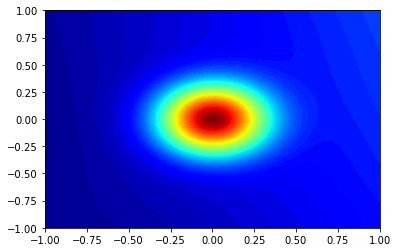

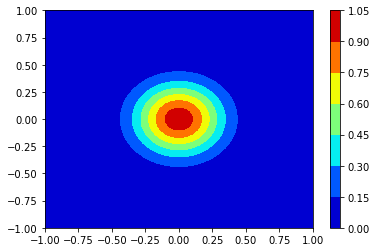

In [19]:
import matplotlib.pyplot as plt
x = torch.linspace(-1, 1, 50).to(device)
y = torch.linspace(-1, 1, 50).to(device)
x, y = torch.meshgrid(x, y)
u_exact = torch.exp(-10 * (x**2 + y**2)).to(device)
u= ui(x, y ,model)
mse = torch.mean((u.reshape(50,50)- torch.exp(-10 * (x**2 + y**2)))**2 )
print(mse)
import matplotlib.pyplot as plt
plt.contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), 100 * ui(x, y, model).cpu().detach().numpy().reshape(50, 50),levels = 100, cmap='jet')
plt.show()


plt.contourf(x,y,u_exact,cmap='jet')
plt.colorbar()
plt.show()

i
3.0467562675476074
(50, 50)
0.03677305202246018


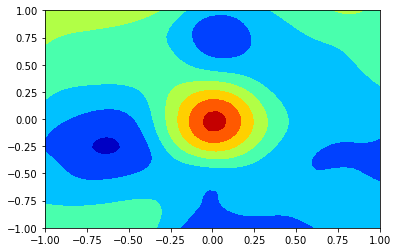

In [56]:
import torch
import torch.nn as nn
import time
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the grid and source function
def create_grid(nx, ny):
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    return torch.meshgrid(x, y)

def source_function(x, y):
    return -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)

# Finite Difference Method for Poisson Equation
def solve_poisson_fd(nx, ny, num_iter=10000):
    # Grid spacing
    hx = 1 / (nx - 1)
    hy = 1 / (ny - 1)
    
    # Create grid and source function
    
    x, y = create_grid(nx, ny)
    f = source_function(x, y)
    u =  ui(x, y ,model).reshape(nx,ny)
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    

    # Initialize u
    
    print('i')
    for _ in range(num_iter):
        u_new = torch.clone(u)
        u_new[1:-1, 1:-1] = 0.25 * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - hx * hy * f[1:-1, 1:-1])
        
        # Enforce boundary conditions (Dirichlet boundary conditions in this case)
        u_new[:, 0] = torch.exp(-10*(x**2+1))
        u_new[:, -1] = torch.exp(-10*(y**2+1))
        u_new[0, :] = torch.exp(-10*(x**2+1))
        u_new[-1, :] = torch.exp(-10*(y**2+1))
        
        u = u_new
    
    return u

# Parameters
nx, ny = 50, 50

start = time.time()
# Solve Poisson equation
u_solution = solve_poisson_fd(nx, ny)
end = time.time()
print(end - start)
# Convert to CPU for plotting if needed
u_cpu = u_solution.cpu().detach().numpy()
print(u_cpu.shape)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
x,y =  np.meshgrid(x, y)
mse = np.mean((u_cpu- np.exp(-10 * (x**2 + y**2)))**2 )
print(mse)
plt.contourf(x, y, u.cpu().detach().numpy().reshape(nx, ny), cmap='jet')


In [15]:
#compute derivatives in Fourier space
def fourier_derivatives(u, dx, dy):
    nx, ny = u.shape[-2], u.shape[-1]
    kx = torch.fft.fftfreq(nx, d=dx).to(u.device)
    ky = torch.fft.fftfreq(ny, d=dy).to(u.device)
    kx, ky = torch.meshgrid(kx, ky)
    
    
    
    u_xx = torch.fft.ifft2(-kx**2 * torch.fft.fft2(u)).real
    u_yy = torch.fft.ifft2(-ky**2 * torch.fft.fft2(u)).real

    return u_xx, u_yy
def f_fourier(x, y, model):
    # Compute the solution using the neural network model
    u = ui(x, y, model)
    
    # Compute Fourier coefficients of the solution
    u_ft = torch.fft.fft2(u)
    
    # Get frequencies
    nx, ny = u.shape[-2], u.shape[-1]
    kx = torch.fft.fftfreq(nx, d=1/nx).to(u.device)
    ky = torch.fft.fftfreq(ny, d=1/ny).to(u.device)
    kx, ky = torch.meshgrid(kx, ky)
    
    # Compute derivatives in Fourier space
    u_xx_ft = -( kx)**2 * u_ft
    u_yy_ft = -( ky)**2 * u_ft
    
    # Transform back to physical space
    u_xx = torch.fft.ifft2(u_xx_ft).real
    u_yy = torch.fft.ifft2(u_yy_ft).real
    
    return u_xx + u_yy

# Compute loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def loss_fn(x, y, model):
    u = ui(x, y, model)
    u_xx, u_yy = fourier_derivatives(u, 2 / (x.shape[-1] - 1), 2 / (y.shape[-1] - 1))
    f_pred = f_fourier(x, y, model)
    f_exact = -torch.exp(-10 * (x**2 + y**2)) * (- 20 * x**2 - 20 * y**2)
    return torch.mean((f_pred - f_exact)**2)

# Train the model

def train(x, y, epochs, modes1, modes2, width, learning_rate=0.001):
    model = FNO2d(modes1, modes2, width).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    nx = len(x[0])
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(x, y, model)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch%100 == 0:
            u_pred = ui(x, y, model).reshape(nx, nx)
            u_exact = torch.exp(-10 * (x**2 + y**2)).to(device)
            mse = torch.mean((u_pred - u_exact)**2)
            print(f'Epoch {epoch}, Loss: {loss.item()} , mse:{mse.item()}')
    return model

# Parameters
nx, ny = 50, 50
modes1, modes2 = 4, 4
width = 120
epochs = 2000

# Create grid
x = torch.linspace(-1, 1, nx).to(device)
y = torch.linspace(-1, 1, ny).to(device)
x, y = torch.meshgrid(x, y)

# Train the model
model = train(x, y, epochs, modes1, modes2, width)



Epoch 0, Loss: 0.10697531700134277 , mse:0.04758286476135254
Epoch 100, Loss: 0.058003365993499756 , mse:0.07229221612215042
Epoch 200, Loss: 0.057919617742300034 , mse:0.07366809248924255
Epoch 300, Loss: 0.05791435018181801 , mse:0.07353828102350235
Epoch 400, Loss: 0.05791380628943443 , mse:0.07349759340286255
Epoch 500, Loss: 0.05791366472840309 , mse:0.073483906686306
Epoch 600, Loss: 0.05791361629962921 , mse:0.07347885519266129
Epoch 700, Loss: 0.05791360139846802 , mse:0.0734768807888031
Epoch 800, Loss: 0.05791359394788742 , mse:0.07347610592842102
Epoch 900, Loss: 0.05791359022259712 , mse:0.07347579300403595
Epoch 1000, Loss: 0.05791359394788742 , mse:0.07347569614648819
Epoch 1100, Loss: 0.05791359394788742 , mse:0.0734756663441658
Epoch 1200, Loss: 0.05791359394788742 , mse:0.0734756588935852
Epoch 1300, Loss: 0.05791359394788742 , mse:0.0734756588935852
Epoch 1400, Loss: 0.05791359394788742 , mse:0.0734756588935852
Epoch 1500, Loss: 0.05791359022259712 , mse:0.07347565889

In [54]:
import matplotlib.pyplot as plt
plt.contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), u.cpu().detach().numpy().reshape(nx, ny), cmap='jet')

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'